In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
from sklearn.metrics import mean_absolute_error, mean_squared_error

from prophet import Prophet

In [9]:
# Load cleaned dataset
df = pd.read_csv("../data/processed/train_clean.csv", parse_dates=["date"])

print("Shape:", df.shape)
print("Date range:", df["date"].min().date(), "to", df["date"].max().date())
print("Stores:", df["store"].nunique(), "Items:", df["item"].nunique())


Shape: (913000, 7)
Date range: 2013-01-01 to 2017-12-31
Stores: 10 Items: 50


In [10]:
# Helper functions
def time_series_for_store_item(data, store_id, item_id):
    s = (
        data[(data["store"] == store_id) & (data["item"] == item_id)]
        .sort_values("date")
        .reset_index(drop=True)
    )
    return s[["date", "sales"]]

def train_test_split_time(series_df, test_size=0.2):
    n = len(series_df)
    split_idx = int(n * (1 - test_size))
    train = series_df.iloc[:split_idx].copy()
    test = series_df.iloc[split_idx:].copy()
    return train, test

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def evaluate_forecast(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape_val = mape(y_true, y_pred)
    print(f"{name:22s} MAE={mae:7.2f}  RMSE={rmse:7.2f}  MAPE={mape_val:7.2f}")
    return {"model": name, "mae": mae, "rmse": rmse, "mape": mape_val}

In [11]:
# Select a store-item pair for demonstration
store_id = 1
item_id = 1

series = time_series_for_store_item(df, store_id, item_id)
train_s, test_s = train_test_split_time(series, test_size=0.2)

print(f"Store {store_id}, Item {item_id}")
print("Train:", train_s["date"].min().date(), "→", train_s["date"].max().date(), "| n =", len(train_s))
print("Test :", test_s["date"].min().date(), "→", test_s["date"].max().date(), "| n =", len(test_s))

# Prepare data for Prophet: columns ds (date) and y (target)
prophet_train = train_s.rename(columns={"date": "ds", "sales": "y"})
prophet_test = test_s.rename(columns={"date": "ds", "sales": "y"})


Store 1, Item 1
Train: 2013-01-01 → 2016-12-30 | n = 1460
Test : 2016-12-31 → 2017-12-31 | n = 366


In [12]:
# Initialize Prophet
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
)

# Fit model
model.fit(prophet_train)

21:23:06 - cmdstanpy - INFO - Chain [1] start processing
21:23:06 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
# Create future dataframe for the test horizon
horizon = len(prophet_test)
future = model.make_future_dataframe(periods=horizon, freq="D")

forecast = model.predict(future)

# Keep only the forecast part corresponding to the test period
forecast_test = forecast.iloc[-horizon:][["ds", "yhat"]].reset_index(drop=True)
forecast_test.columns = ["ds", "yhat"]

# Align with actual test data
y_true = prophet_test["y"].values
y_pred = forecast_test["yhat"].values

prophet_results = evaluate_forecast("Prophet", y_true, y_pred)


Prophet                MAE=   4.08  RMSE=   5.01  MAPE=  22.64


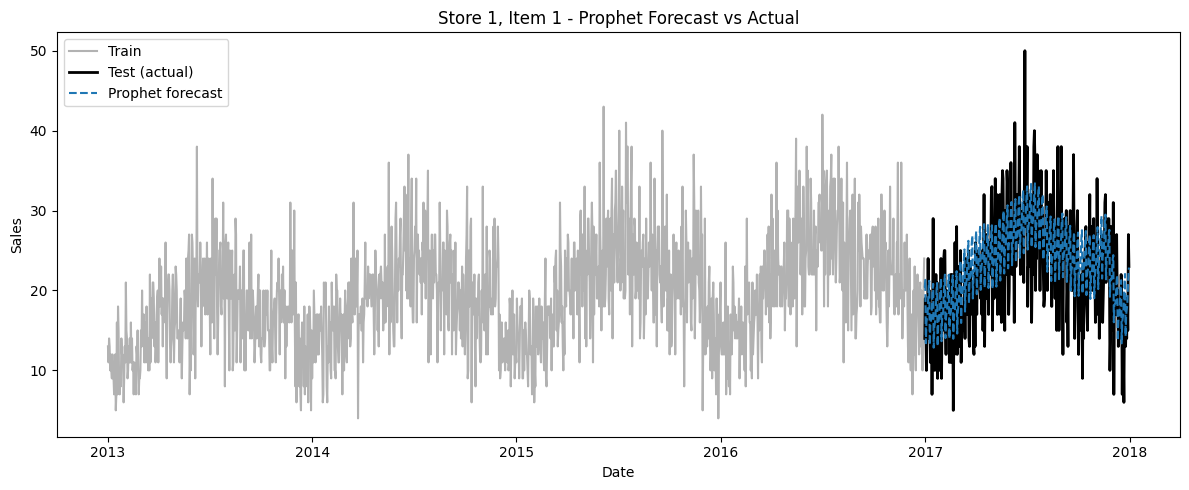

In [14]:
# Plot Prophet forecast vs. actual test data
plt.figure(figsize=(12, 5))

# Training data
plt.plot(train_s["date"], train_s["sales"], label="Train", color="gray", alpha=0.6)

# Actual test data
plt.plot(test_s["date"], test_s["sales"], label="Test (actual)", color="black", linewidth=2)

# Prophet forecast on test period
plt.plot(forecast_test["ds"], forecast_test["yhat"], label="Prophet forecast", linestyle="--", color="tab:blue")

plt.title(f"Store {store_id}, Item {item_id} - Prophet Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()
